# Markov Chains
A Markov chain is a random process with the **Markov Property**.

<center>
    <b><i>The probability of transitioning to any particular state is dependent solely on the current state and time elapsed, and not on the sequence of states that preceeded (memoryless)</b></it>
</center>

A random process is a collection of random variables. A Markov chain has:
* Discrete state space (set of possible values that the random variables can assume)
* Discrete index set (often representing time)

## Discrete Time Markov chain
A discrete-time Markov chain represents a system which is in a certain state at each step, with its state changing randomly between steps. It is a sequence of random variables $X_1, X_2, ...$. Together with the Markov property, we can represent this as follows

$$
P(X_{n+1} = x | X_1 = x_1, X_2 = x_2, ..., X_n = x_n) = P(X_{n+1} = x | X_n = x_n)
$$

The possible values of $X_i$ form the *state space*. While the time parameter is usually discrete, there are no formal rule on the definition of the state space. Anyway, usually applications of Markov Chains assume a finite state space.

## Model
The changes of state of the system are called *transitions* and the probabilities associated with various state changes are called *transition probabilities*. A *probabilistic automaton* includes the probability of a given transition into the transition function, turning it into a *transition matrix*.

### The transition matrix
The transition matrix from time $n$ to time $n + 1$ is represented as follows
$$ T_{n} = 
\left(\begin{array}[c, c, c]\\
s_{11} & ... & s_{1N} \\
\vdots & \ddots & \vdots \\
s_{N1} & ... & s_{NN}
\end{array}\right)
$$
where $N$ is the total number of states and $s_{ij}$ is the probability, at time $n$, of transitioning from state $i$ to state $j$. It must be noticed that 
$$
\sum_{j=1}^N s_ij = 1, \forall i \in \{1, ..., N\}
$$

### Properties of Markov Chains
1. **Reducibility**: a Markov chain is said to be *irreducible* if it is possible to get to any state from any state
2. **Periodicity**: a state in a Markov chain is said to be *periodic* if the chain can return to the state only at multiples of some integer larger than 1. 
3. **Transience and Recurrence**: a state $i$ is said to be *transient* if, given that we start at $i$, there is a non-zero probability that we will never return to $i$. A state $i$ is said to be *recurrent* if it is not transient. It is said to be *positive recurrent* if it is expected to return within a finite number of steps and *null recurrent* otherwise.
4. **Ergodicity**: a state $i$ is said to be *ergodic* if it is not periodic and positive recurrent
5. **Absorbing state**: a state $i$ is said to be *absorbing* if it is impossible to leave this state. If every state can reach an absorbing state, the whole chain is called absorbing.

In [60]:
import numpy as np
import pandas as pd
import networkx as nx
from tqdm import tqdm
import wget
from collections import defaultdict
import matplotlib.pyplot as plt

In [2]:
N_states = 3
state_space = list(range(N_states))
state_space_names = ['state_' + str(i) for i in state_space]

transition_matrix = np.random.uniform(size=(N_states, N_states))
transition_matrix = transition_matrix / transition_matrix.sum(1)[:, np.newaxis]
pd.DataFrame(data=transition_matrix, columns=state_space_names, index=state_space_names)

,state_0,state_1,state_2
state_0,0.270716,0.315616,0.413668
state_1,0.338522,0.351995,0.309483
state_2,0.129626,0.442726,0.427648


## Simulating the Markov Chain

In [33]:
n_steps = 100
starting_state = 0
current_state = starting_state

state_sequence = [current_state]
for _ in tqdm(range(n_steps)):
    current_state = np.random.choice(state_space, p=transition_matrix[current_state, :])
    state_sequence.append(current_state)

100%|██████████| 100/100 [00:00<00:00, 33380.85it/s]


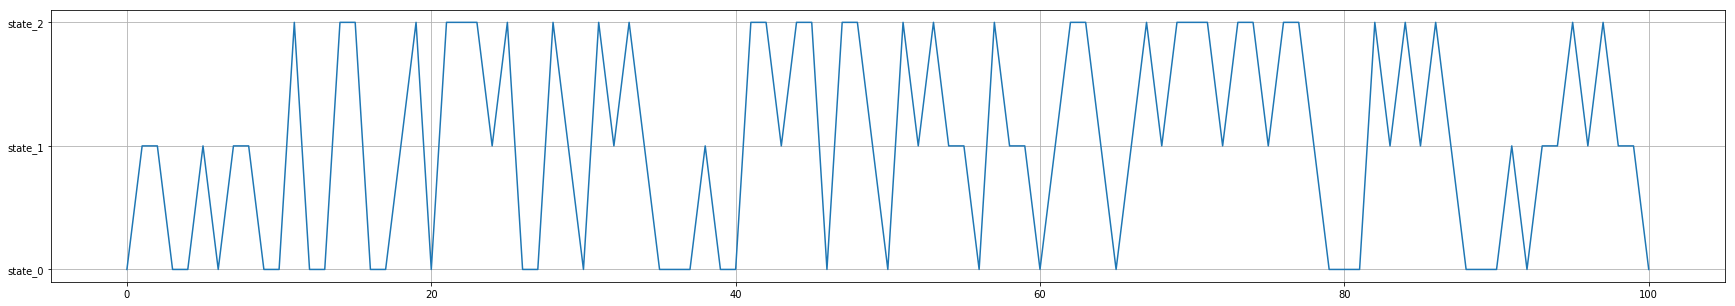

In [35]:
plt.figure(figsize=(30, 5))
plt.plot(range(n_steps + 1), state_sequence)
plt.yticks(state_space, state_space_names)
plt.grid()
plt.show()

In [31]:
statistics = []
for state in state_space:
    s_stats = {}
    s_stats['state'] = state_space_names[state]
    s_stats['n_visits'] = state_sequence.count(state)
    s_stats['perc_visits'] = s_stats['n_visits'] / n_steps
    
    statistics.append(s_stats)
pd.DataFrame.from_dict(statistics).set_index("state")

,n_visits,perc_visits
state,,
state_0,236,0.236
state_1,382,0.382
state_2,383,0.383


## Example: simulating a Trump speech using Markov Chains
Let's apply the Markov Chain model to the generation of speech.

We will make use of a small dataset of Trump speeches available at [this Github repository](https://github.com/ryanmcdermott/trump-speeches).
This example is adapted from [this Medium post](https://towardsdatascience.com/simulating-text-with-markov-chains-in-python-1a27e6d13fc6)

### Download the speech dataset

In [39]:
speech_path = wget.download("https://raw.githubusercontent.com/ryanmcdermott/trump-speeches/master/speeches.txt", out="./data/")

### Filtering the corpus
We will split the speeches in words and then filter out all the non-words (strings with numbers and the headers of the speeches).

In [42]:
text = open(speech_path, encoding='utf8').read()
corpus = text.split()

def is_allowed(word):
    return ("SPEECH" not in word) and (all(str.isalpha(c) for c in word))

corpus = list(filter(is_allowed, corpus))

### Creating the transition matrix
We won't create the transition matrix as in the previous example, since a great part of the transitions between words will have zero probability and therefore we would create a huge matrix to store very little information. Instead we choose to store the transition matrix as a dictionary

    word_dict[word_i] = [word_i1, word_i2, ...]

where, for each word in the corpus, we store the list of the words which happen to be after it in the text. Notice that **we keep duplicate words** in order to have an higher probability to pick up them during the simulation.

In [82]:
def make_pairs(corpus):
    for i in range(len(corpus)-1):
        yield (corpus[i], corpus[i+1])
        
pairs = make_pairs(corpus)

word_dict = defaultdict(list, [])

for word_1, word_2 in pairs:
    word_dict[word_1].append(word_2)

### The simulated speech
The simulation/generation part is similar to the previous example. We only add the constrain that the first word (starting state of the chain) must be one with an upper case letter as first letter.

In [80]:
n_words = 20

first_word = np.random.choice(list(filter(lambda w: not w.islower(), corpus)))
chain = [first_word]

for _ in range(n_words):
    chain.append(np.random.choice(word_dict[chain[-1]]))

In [81]:
print(" ".join(chain))

How about I got feet with Hillary said All I have I rebuilding America great Believe We have so And the
